# <p style="text-align: center;"> Home work on Attentional LSTM network </p>
### <p style="text-align: center;"> Aglind Reka </p>
### <p style="text-align: center;"> Worked in collaboration with Paul Peyssard, Trang Nguyen, Matheus Paula </p>
#### <p style="text-align: center;"> MSc Data Science & Artificial Intelligence </p>
#### <p style="text-align: center;"> Intro to deep learning </p> 
#### <p style="text-align: center;"> 11/02/2023 </p>

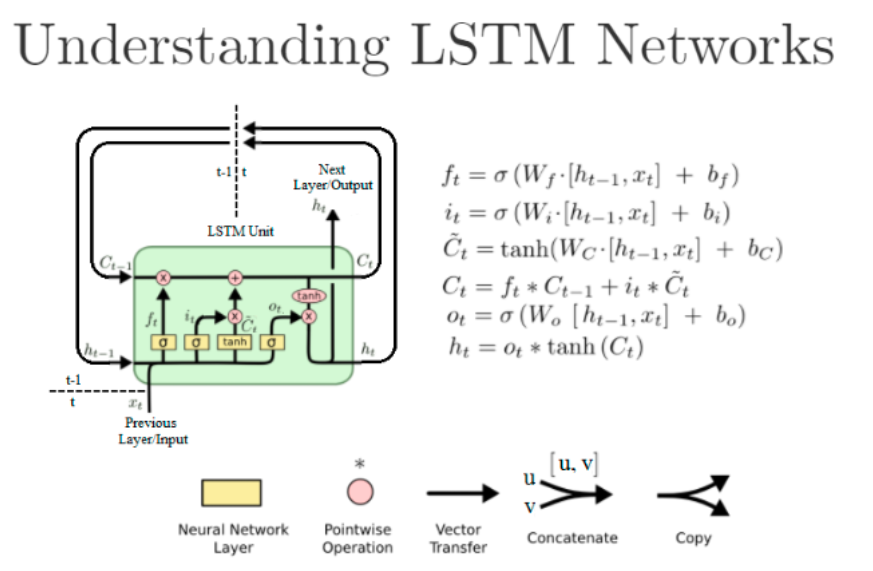

# Libraries

We start by importing the libraries we will need during our code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, RMSprop


In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, f1_score,cohen_kappa_score

In [4]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.porter import PorterStemmer

# Dataset

Now let's download our data.

In [5]:
train = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
val = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
test = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

### a) Checking the data

Shape of our data.

In [6]:
print("Train shape : ",train.shape)
print("Test shape : ",test.shape)
print("Val shape : ",val.shape)

Train shape :  (5000, 6)
Test shape :  (1000, 6)
Val shape :  (1000, 6)


In [7]:
np.unique(train['Rating'])

array([1, 2, 3, 4, 5], dtype=int64)

As we can see, there is a total of five classes, representing each possible rating value (1,2,3,4 or 5).

Let's see how our dataframe looks now.

In [8]:
train.head(5)

Product Name Brand Name   Price  \
0  Samsung Galaxy Note 4 N910C Unlocked Cellphone...    Samsung  449.99   
1  BLU Energy X Plus Smartphone - With 4000 mAh S...        BLU  139.00   
2                   Apple iPhone 6 128GB Silver AT&T      Apple  599.95   
3  BLU Advance 4.0L Unlocked Smartphone -US GSM -...        BLU   51.99   
4  Huawei P8 Lite US Version- 5 Unlocked Android ...     Huawei  198.99   

   Rating                                            Reviews  Review Votes  
0       4             I love it!!! I absolutely love it!! üëåüëç           0.0  
1       5  I love the BLU phones! This is my second one t...           4.0  
2       5                                        Great phone           1.0  
3       4  Very happy with the performance. The apps work...           2.0  
4       5                            Easy to use great price           0.0

Let's also check the type of each of our columns.

In [9]:
train.dtypes

Product Name     object
Brand Name       object
Price           float64
Rating            int64
Reviews          object
Review Votes    float64
dtype: object

### b) Build X (features vectors) and y (labels)

For our particular problem, as we did in a previous lab, we will use "Reviews" as our explanatory data (X) and Rating as our target (Y). In other words, we want our classifier to predict a rating for a particular review.

We start by preprocessing our data. Removing null values and reshaping it so we can vectorize it later.

In [10]:
# Construct X_train and y_train
X_train = train['Reviews'].fillna("")
X_train = np.array(train['Reviews'].fillna("")).reshape(-1,1)
y_train = train['Rating']
y_train = np.array(train['Rating']).reshape(-1,1)
X_train.shape, y_train.shape

((5000, 1), (5000, 1))

In [11]:
# Construct X_test and y_test
X_test = test['Reviews'].fillna("")
X_test = np.array(test['Reviews']).reshape(-1,1)
y_test = test['Rating']
y_test = np.array(test['Rating']).reshape(-1,1)
X_test.shape, y_test.shape

((1000, 1), (1000, 1))

In [12]:
# Construct X_val and y_val
X_val = val['Reviews'].fillna("")
X_val = np.array(val['Reviews']).reshape(-1,1)
y_val = val['Rating']
y_val = np.array(val['Rating']).reshape(-1,1)
X_val.shape, y_val.shape

((1000, 1), (1000, 1))

### c) One-hot-encoding

Just like we are going to vectorize our input, we also need to vectorize our target labels so our neural network can learn with it. For this, we can use one-hot encoding.

In [13]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_val_encoded = ohe.transform(y_val)
y_test_encoded = ohe.transform(y_test)

### e) Text preprocessing

We need to do some preprocessing in our text before we can input it to our neural network. For this we can use the Natural Language Toolkit, or "nltk": https://www.nltk.org/

We need to download a few packages in order to be able to use it to remove stop words from our text data (the review data). A stop word is a commonly used word that should be ignored during the processing of text data for machine/deep learning purposes. nltk provides us with a library of common stopwords in various languages, including English, so we can remove them seamlessly from our text data.

In [14]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raffaele\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raffaele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Raffaele\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Raffaele\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We now write a function ``del_stops`` to delete our stop words from out text data.

In [15]:
def del_stops(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if w not in stops:
            filtered_sentence.append(w)
    result=' '.join(filtered_sentence)
    return result

We still need to do some other preprocessing with our text data. For example, it is littered with emojis and non-latin characters. We also need to add tags indicating the start and end of each review. Below, we write a function to clean the data of emojis, non-latin characters and other kinds of special characters.

In [16]:
# Process the data
import unicodedata

def step1(sent):
    # sent = on sentence in a language
    def unicode_to_ascii(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    sent = unicode_to_ascii(sent.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    sent = re.sub(r"([?.!,¬ø])", r" \1 ", sent)
    sent = re.sub(r'[" "]+', " ", sent)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sent = re.sub(r"[^a-zA-Z?.!,¬ø]+", " ", sent)
    
    #removing emojis and non latin symbols (chinese, russian etc...)
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    sent= re.sub(emoj, '', sent)
    

    return '<start> ' + sent.strip() + ' <end>' # and start and stop tag

Unite those functions into one single function, ``clean_text``.

In [17]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
lemmatizer = WordNetLemmatizer()
import re
#Those are the cleaning functions we already used in previous machine learning labs

def clean_text(text):
    text=text.lower() #lowercase the text
    #text=re.sub(r'[^\w\s]', '', text) #remove punctuation  Voir si besoin de √ßa
    text=del_stops(text) #delete stop words
    text=lemmatizer.lemmatize(text)
    text=step1(text)
    return text

Now let us apply this to our data.

In [18]:
X_train_p = np.array([clean_text(r) for r in X_train.flatten()])
X_test_p = np.array([clean_text(r) for r in X_test.flatten()])
X_val_p = np.array([clean_text(r) for r in X_val.flatten().astype(str)]) 

Confirm if it worked.

In [19]:
X_train[0]
X_train_p[0]

'<start> love ! ! ! absolutely love ! ! <end>'

### Defining the babysit function in order to observe the learning curves of the models

This function is very similar to the function we used in previous labs. It basically plots a graph with the evolution of the neural network during its learning process.

In [20]:
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

# Model

The constants that we will need to build our model.

In [21]:
BATCH_SIZE = 32
embedding_dim = 50
latent_dim = 64
dropout=0.3
recurrent_size = 64 
nb_classes = 5
vocab_size = 10 ** 4  # Maximum vocab size -- adjust with the size of the vocabulary
embedding_size = 20  # Embedding size (usually <= 300)
recurrent_size = 64  # Recurrent size
hidden_size = recurrent_size // 4  # Hidden layer
dropout_rate = 0.2  # Dropout rate for regularization (usually between 0.1 and 0.25)
max_len = 150  # Sequence length to pad the outputs to (deduced from the length distribution study)
learning_rate = 0.0075

We now declare a function called ``voc`` which will give us some information about our vocabulary corpus. It basically returns three values: ``the length of the biggest vectorized vocab array, the vocab array itself as a list and the number of vocabularies itself + 2 (for padding and creating out-of-vocabulary embeddings). We will need this information for our embedding layer later.``

In [22]:
def voc(lang):
    lengths = [len(txt.split()) for txt in lang]
    vocab = set([w for txt in lang for w in txt.split()])  
    return max(lengths), list(vocab), len(vocab)+2 # for padding and OOV

max_length_reviews, vocab_reviews, vocab_size_reviews = voc(X_train_p)
rate_size=5
print(max_length_reviews, vocab_size_reviews,rate_size)


704 8452 5


``TextVectorization is a technique used in natural language processing to convert raw text data into numerical vectors that can be processed by machine learning models. It is a preprocessing step that is often used to prepare text data for tasks such as sentiment analysis, language modeling, and text classification.``

Vectorizer for our reviews, which will transform our strings into a numerical vectorized representation and build a vocabulary linked to said representation while at it.
 
It is possible to build your own function, to transform emoji into text, to transform foreign reviews in english one, etc.

In [23]:
reviews_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size_reviews,
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=max_length_reviews,
)

reviews_vectorizer.adapt(X_train_p)


### Let's build the model

We start by building our input layer, which will take an one-dimensional list of reviews - represented as strings - as input.

In [24]:
inputLayer = layers.Input(shape=(1,), name="input", dtype=tf.string)

We need to vectorize our text data - transform it into an array of numbers linked to a vocabulary - before we can learn with it as neural networks cannot learn with text data itself. So we vectorize our text data.

In [25]:
vect = reviews_vectorizer(inputLayer)

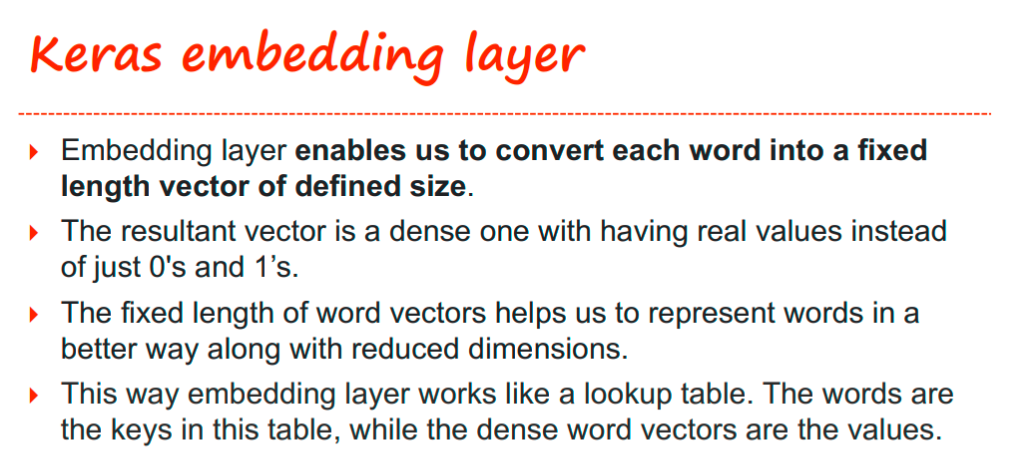

We add an embedding layer so our neural network can learn the correct word embeddings. This lets the neural network transform our text data into vectorized data, and lets us be sure that our sequences are of the same length (``embedding_size``).

In [26]:
embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_size,
    weights=None,  # Without pre-learning
    trainable=True,  # Trainable
    name="embedding",
)(vect)

Add a layer with recurrent (GRU) cells. The GRU cell processes the sequences of input data by selectively updating and resetting its hidden state at each time step, allowing it to capture long-term dependencies in the input sequence. ``recurrent_size`` is the number of hidden units in the layer, while ``return_sequences``, if set to True, will make the neural network return an output for each time step in the sequence, and ``return_state`` does the same but only for the state. In this case we just want the sequences so we set ``return_sequences`` to ``True`` and ``return_state`` to ``False``.

In [27]:
rnn = layers.GRU(
    recurrent_size,
    return_sequences=True,
    return_state=False,
    dropout=dropout_rate,
    recurrent_dropout=dropout_rate,
)(embedding)

## Attention

The last output of our GRU layer is a context vector of fixed size. A critical disadvantage with working with a context vector of fixed size is that the network becomes incapable of remembering the large sentences. We can often face problems like forgetting the starting part of the sequence after processing the whole sequence, for example. To solve this issue, we can use an attention mechanism.

A attention mechanism is a mechanism that can help a neural network to memorize long sequences of the information or data. It does so by creating a shortcut between the entire input and the context vector where the weights of the shortcut connection can be changeable for every output. 

For our structure, we will create a Dense layer with one unit and which uses ``tanh`` as the activation function to serve as the attention layers. It will map the output of GRU to an attention score (a single one) for each time step in the input sequence.

In [28]:
attention = layers.Dense(1, activation="tanh")(rnn)

This line flattens the output of the previous Dense layer to a 1 dimension tensor. This gives us the probability distribution over the time steps of the GRU.

In [29]:
attention = layers.Flatten()(attention)

Although we did not see Repeat Vector in class, We decided to introduce the idea in this assignment as our structure is not exactly the same we saw in class.

The Repeat Vector is used to create a tensor with the shape ``(batch_size,timesteps,recurrent)`` by repeating the attention scores tensor along the time step dimension.

There is more information about it in this article: https://towardsdatascience.com/gru-recurrent-neural-networks-a-smart-way-to-predict-sequences-in-python-80864e4fe9f6

In [30]:
attention = layers.RepeatVector(recurrent_size)(attention)  # RNN Normal

We now create a "Permute" layer, which is used to transpose the dimension of the tensor. It is necessary to ensure that the attention score are correctly aligned with the ouput of GRU layer when attention is applied to its output.


In [31]:
attention = layers.Permute([2, 1])(attention)

Compute the dot product of the layers (GRU and attention), so we can have our final weighted sentence. The importance of each time step is determined by the corresponding attention score.

In [32]:
sent_representation = layers.Dot(axes=1, normalize=False)([rnn, attention])

Flatten the output of the dot product so we can transport it to our next layer.

In [33]:
flatten = layers.Flatten()(sent_representation)

Then apply dropout to prevent overfitting.

In [34]:
hidden_dense = layers.Dropout(dropout_rate)(flatten)

Output layer of the model

In [35]:
outputLayer = layers.Dense(nb_classes, activation="softmax")(hidden_dense)

Create the model with its input and output

In [36]:
model = Model(inputs=inputLayer, outputs=outputLayer)

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 704)         0           ['input[0][0]']                  
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, 704, 20)      200000      ['text_vectorization[0][0]']     
                                                                                                  
 gru (GRU)                      (None, 704, 64)      16512       ['embedding[0][0]']          

Early stopping, so the neural network stops learning when accuracy stops improving.

In [38]:
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=5, restore_best_weights=True, verbose=1,
                                )]


Adam optimizer to use when compiling our model

In [39]:
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Compile it.

In [40]:
model.compile(optimizer=op, loss="categorical_crossentropy", metrics='accuracy')


Fit the model to your data and make it learn.

In [41]:
history = model.fit(X_train_p,y_train_encoded,
                    validation_data=(X_val_p, y_val_encoded),
                    epochs=4000, batch_size=BATCH_SIZE,
                    callbacks=callbacks_list,
                    verbose=1)

Epoch 1/4000
157/157 [==============================] - 131s 796ms/step - loss: 2.7656 - accuracy: 0.4666 - val_loss: 1.1656 - val_accuracy: 0.5880
Epoch 2/4000
157/157 [==============================] - 115s 732ms/step - loss: 1.0510 - accuracy: 0.6372 - val_loss: 0.9788 - val_accuracy: 0.6740
Epoch 3/4000
157/157 [==============================] - 120s 763ms/step - loss: 0.7720 - accuracy: 0.7266 - val_loss: 1.0335 - val_accuracy: 0.6690
Epoch 4/4000
157/157 [==============================] - 118s 751ms/step - loss: 0.5859 - accuracy: 0.8008 - val_loss: 1.2832 - val_accuracy: 0.6770
Epoch 5/4000
157/157 [==============================] - 115s 732ms/step - loss: 0.4762 - accuracy: 0.8358 - val_loss: 1.5732 - val_accuracy: 0.6060
Epoch 6/4000
157/157 [==============================] - 118s 754ms/step - loss: 0.4257 - accuracy: 0.8572 - val_loss: 1.8569 - val_accuracy: 0.6420
Epoch 7/4000
157/157 [==============================] - 115s 732ms/step - loss: 0.4575 - accuracy: 0.8564 - val_

Evolution of our neural network in terms of loss and accuracy, for both training and validation data.
We're going to print the evolution of the moodel.

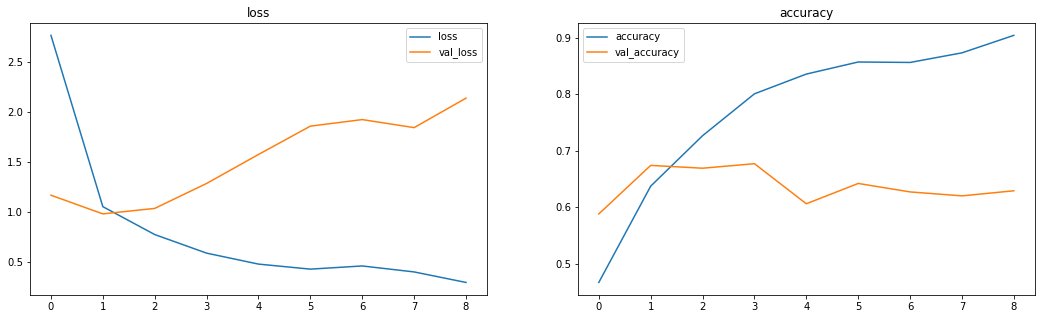

In [42]:
babysit(history.history)

Like I see, I have an overfitting, I think is normal because our dataset is unbalanced.
But in general I see a good model because the model learns, and I don't see a big overfitting in the train data vs validation data.

''ConfusionMatrix''

We predict and plot our confusion matrix to see how well our neural network is working in terms of prediction.

The matrix presents a summary of the predictions made by a model on a set of input data compared to the actual outcomes. It allows us to determine the accuracy and performance of a model.

In a confusion matrix, the rows represent the true labels of the data, while the columns represent the predicted labels. The matrix shows the number of correct and incorrect predictions made by the model, broken down by the different classes in the data.

The confusion matrix is particularly useful for evaluating the performance of a classification algorithm in situations where the classes are imbalanced or where the cost of misclassification is different for different classes. It can be used to calculate metrics such as accuracy, precision, recall, and F1 score, which are commonly used to evaluate the performance of machine learning algorithms.

157/157 [==============================] - 20s 117ms/step


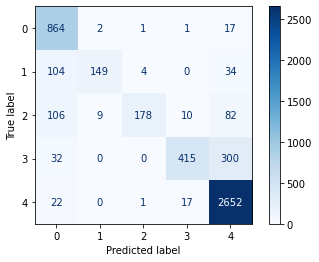

In [43]:
y_pred=model.predict(X_train_p)
ConfusionMatrixDisplay.from_predictions(y_train_encoded.argmax(1), y_pred.argmax(1), cmap="Blues")

Like we can see, our neural network has fairly decent accuracy, reaching about 63% accuracy in total, and exhibiting a confusion matrix with very few mistakes per class, being able to properly predict even the non-extreme ratings fairly well. It is also learning, as we can see from the trend of loss decrease and accuracy increase. However, it does suffer quite a bit with early overfitting even after using dropout